In [124]:
import numpy as np
import pandas as pd
import re
import warnings 
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.colors import n_colors
from plotly.subplots import make_subplots
init_notebook_mode(connected= True)
import cufflinks as cf
cf.go_offline()
from wordcloud import WordCloud, ImageColorGenerator 
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob

In [125]:
df= pd.read_csv('/kaggle/input/indian-products-on-amazon/amazon_vfl_reviews.csv')
df.head()

,asin,name,date,rating,review
0,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-09-06,1,I bought this hair oil after viewing so many g...
1,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-08-14,5,Used This Mama Earth Newly Launched Onion Oil ...
2,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-10-19,1,So bad product...My hair falling increase too ...
3,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-09-16,1,Product just smells similar to navarathna hair...
4,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-08-18,5,I have been trying different onion oil for my ...


In [126]:
df.isnull().sum()
df.shape

(2782, 5)

In [127]:
df.dropna(inplace= True)
df = df.reset_index()
df.drop(['index'], axis = 1, inplace= True) 
df.shape

(2778, 5)

In [128]:
def get_brand(x):
    return x.split('-')[0]

df['brand']= df['name'].apply(get_brand)
df['brand'].unique()

array(['Mamaearth', 'Godrej', 'Titan', 'Maaza', 'Paper', 'Indiana',
       'Coca', 'Natural', 'Maggi', 'Glucon', 'Amul', 'Patanjali',
       'PATANJALI', 'Dettol', 'Savlon', 'Cinthol', 'Britannia',
       'NutriChoice', 'Streax', 'Himalaya', 'Society', 'Tata', 'Fastrack',
       'Reflex', 'MYSORE', 'Mysore'], dtype=object)

In [129]:
df['brand'] = df['brand'].str.replace('PATANJALI', 'Patanjali')
df['brand'] = df['brand'].str.replace('MYSORE', 'Mysore')

#number of unique brands
len(df['brand'].unique())

24

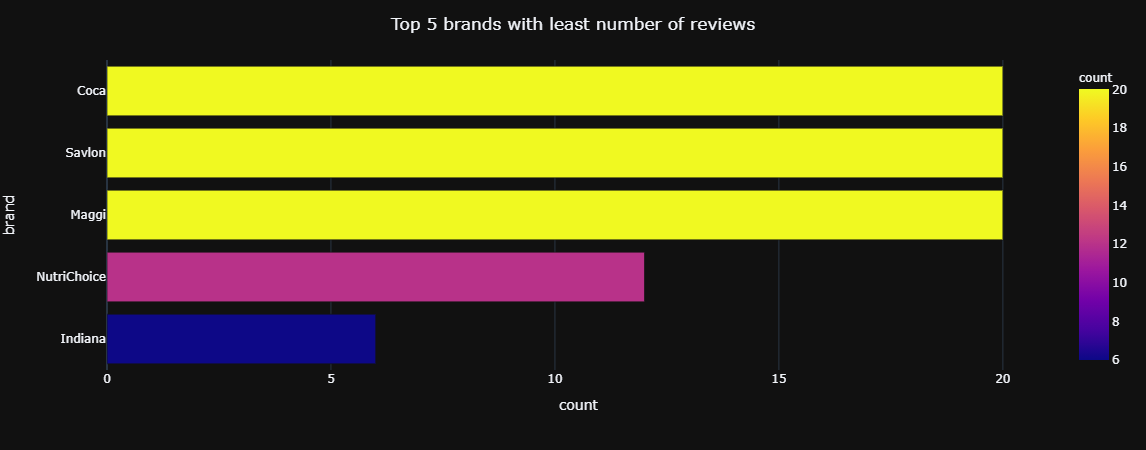

In [130]:
df1= pd.DataFrame(df.groupby('brand')['asin'].count().reset_index())
df1.columns= ['brand', 'count']

sort_df= df1.sort_values(['count'], ascending= True)

fig= px.bar(sort_df.iloc[:5, :], y= 'brand', x= 'count', orientation= 'h', color= 'count')
fig.update_layout(title_text= 'Top 5 brands with least number of reviews', title_x= .5, template= 'plotly_dark')
fig.show()

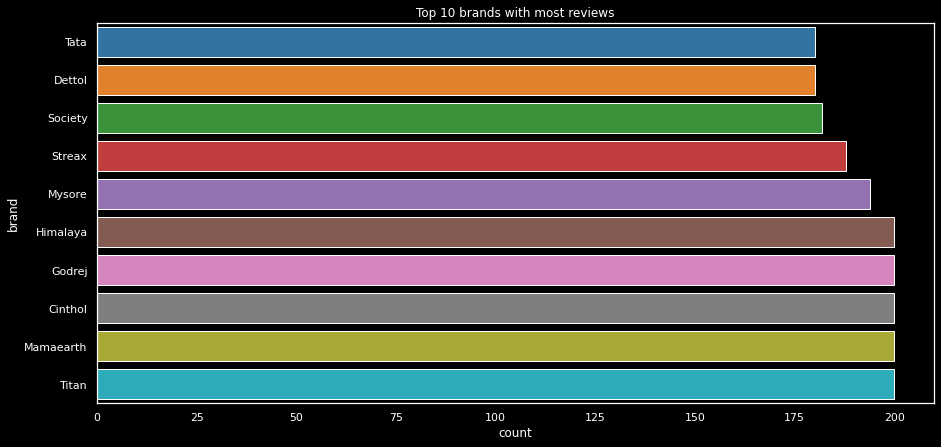

In [131]:
import seaborn as sns
sns.set(rc={'figure.figsize':(15,7)})
sns.set_theme(style="darkgrid")
plt.style.use("dark_background")
plt.title('Top 10 brands with most reviews')
sns.barplot(x= sort_df['count'].tail(10) , y= sort_df['brand'].tail(10), palette= 'tab10' ).grid(False)

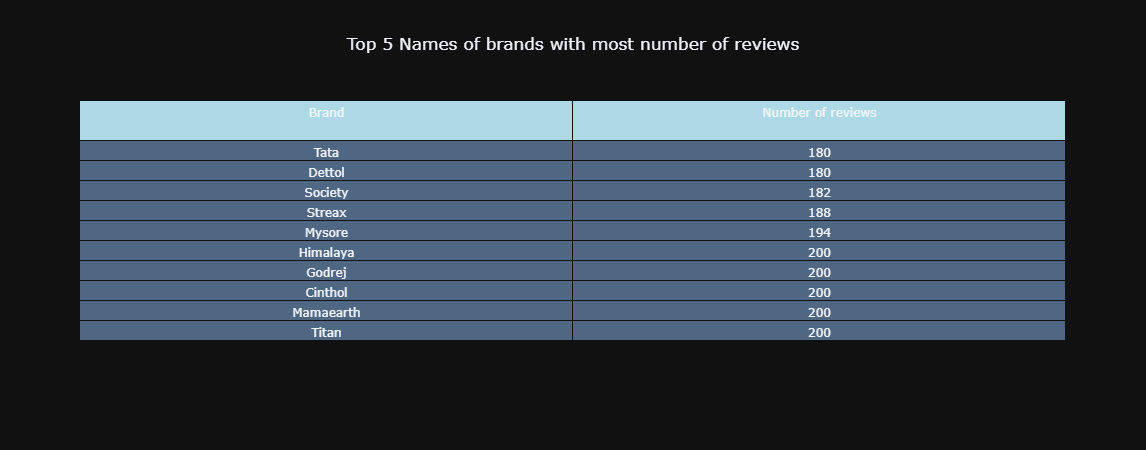

In [132]:
brand= sort_df.iloc[-10: , :]['brand'].to_list()
count= sort_df.iloc[-10: , :]['count'].to_list()

fig= go.Figure(data= [go.Table(header= dict(values= ['Brand', 'Number of reviews'], fill_color= 'lightblue', height= 40 ),
                              cells= dict(values=[brand, count], height= 20))])
fig.update_layout(title_text='Top 5 Names of brands with most number of reviews',title_x=0.5,
                  template='plotly_dark')

fig.show()

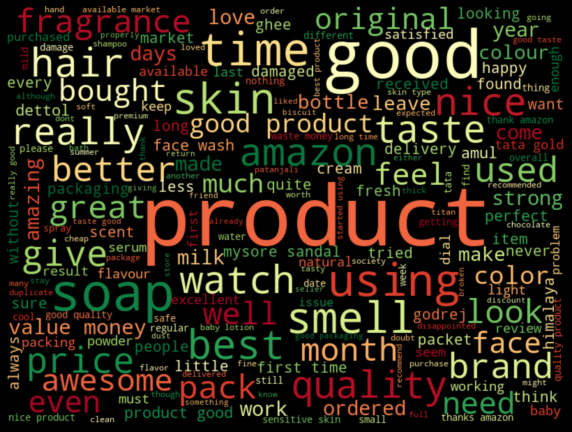

In [135]:
stop_words = stopwords.words('english')

corpus = []
for i in range(0,len(df)):
    text= re.sub('[^a-zA-Z]', ' ', df['review'][i])
    text= text.lower()
    text= text.split()
    text= [word for word in text if not word in stop_words]
    text= ' '.join(text)
    corpus.append(text)
    
word_cloud = WordCloud(width = 800,
                       height = 600,
                       colormap = 'RdYlGn', 
                       margin = 0,
                       max_words = 200,  
                       min_word_length = 4,
                       max_font_size = 120, 
                       background_color = 'black').generate(' '.join(corpus))


plt.figure(figsize = (10, 10))
plt.imshow(word_cloud, interpolation = 'gaussian')
plt.axis('off')
plt.show()

In [16]:
rating= pd.DataFrame(df['rating'].value_counts().reset_index())
rating.columns= ['rating', 'count']

rating.sort_values('rating', ascending= False, inplace= True)
rating

,rating,count
0,5,1444
2,4,460
3,3,198
4,2,130
1,1,546


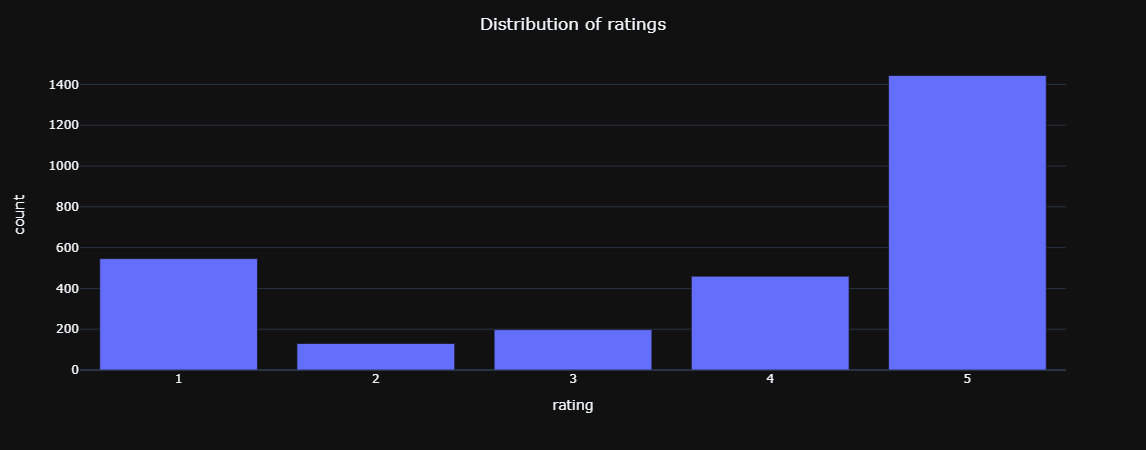

In [136]:
fig= px.bar(rating, x= 'rating', y= 'count')
fig.update_layout(title_text= 'Distribution of ratings', title_x= 0.5, template= 'plotly_dark')
fig.show()

In [138]:
def polarity(text):
    return TextBlob(text).sentiment.polarity

df['polarity_score']= df['review'].apply(lambda x : polarity(x))

def sentiment(x):
    if x<0:
        return 'negative'
    elif x==0:
        return 'neutral'
    else:
        return 'positive'
    
df['polarity'] = df['polarity_score'].\
   map(lambda x: sentiment(x))

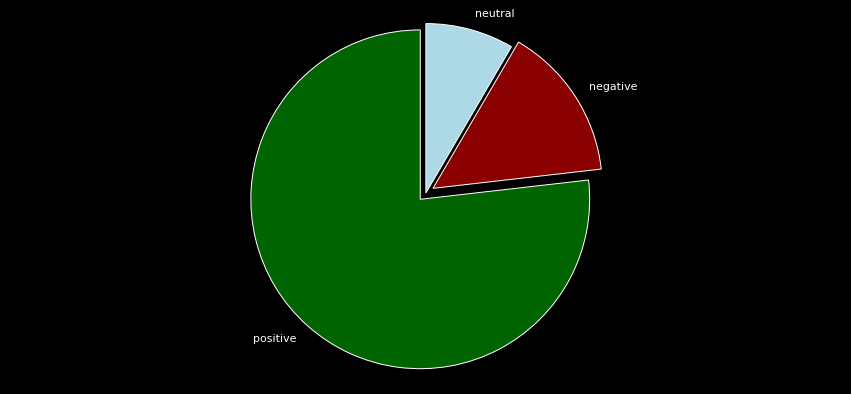

In [161]:
values = df['polarity'].value_counts()
labels= df['polarity'].value_counts().index
plt.pie(values , labels= labels ,explode= (.05,.05,0),
          colors=['#006400','#8B0000','#add8e6'],startangle= 90)
plt.axis('equal')
plt.show()

# Text summarization Extractive method

In [107]:
from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance
import numpy as np
import networkx as nx

In [108]:
def sentence_similarity(sent1, sent2, stopwords=None):
    if stopwords is None:
        stopwords = []
 
    sent1 = [w.lower() for w in sent1]
    sent2 = [w.lower() for w in sent2]
 
    all_words = list(set(sent1 + sent2))
 
    vector1 = [0] * len(all_words)
    vector2 = [0] * len(all_words)
 
    # build the vector for the first sentence
    for w in sent1:
        if w in stopwords:
            continue
        vector1[all_words.index(w)] += 1
 
    # build the vector for the second sentence
    for w in sent2:
        if w in stopwords:
            continue
        vector2[all_words.index(w)] += 1
 
    return 1 - cosine_distance(vector1, vector2)
 
def build_similarity_matrix(sentences, stop_words):
    # Create an empty similarity matrix
    similarity_matrix = np.zeros((len(sentences), len(sentences)))
 
    for idx1 in range(len(sentences)):
        for idx2 in range(len(sentences)):
            if idx1 == idx2: #ignore if both are same sentences
                continue 
            similarity_matrix[idx1][idx2] = sentence_similarity(sentences[idx1], sentences[idx2], stop_words)

    return similarity_matrix


def generate_summary(rawtext, top_n=2):
    stop_words = stopwords.words('english')
    summarize_text = []

    article = rawtext.split(". ")
    sentences = []

    for sentence in article:
        sentences.append(sentence.replace("[^a-zA-Z]", " ").split(" "))

    sentence_similarity_martix = build_similarity_matrix(sentences, stop_words)

    sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_martix)
    scores = nx.pagerank(sentence_similarity_graph)

    ranked_sentence = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)    

    for i in range(top_n):
        summarize_text.append(" ".join(ranked_sentence[i][1]))

    return ". ".join(summarize_text)

In [109]:
generate_summary(df['review'][5], 1)

"My hair doesn't lump in together as with other hair oil products.4.Gives a pretty good shine and dark color5"

In [121]:
extract_summary= []
for i in range(0,10):
    summary= generate_summary(df['review'][i], 1)
    extract_summary.append(summary)

In [122]:
for i in range(0,10):
    print("rating:", df['rating'][i], " Summary:" , extract_summary[i],'\n' )

rating: 1  Summary: But this product is not good enough.First of all it's Expensive...Second thing the amount of the product is low (half bottle) YES!The bottle is not completely filled with oil 

rating: 5  Summary: Used This Mama Earth Newly Launched Onion Oil twice, and i must say im already impressed by the results !It prevents hair loss, helps control premature greying, dryness, dandruff, scalp eruptions and many other hair problems after its regular use !To avoid dry and frizzy hair, make sure that you use this oil to your hairs twice a week.Oiling provides your scalp with essential nutrients, and also strengthens the hair roots 

rating: 1  Summary: nothing stop hairfallAfter 3 to 4 wash my hair falling so badly... 

rating: 1  Summary: but not strong as that and oil is not sticky after applying three drops of oil !! More review after usage of 2 months1) worst product2) hair fall increased a lot3) brought this product after watching YouTube influencer Mumbaiker Nikhil4) totally 

# Abstractive summarization using HuggingFace Transformers

In [33]:
from transformers import pipeline
summarizer  = pipeline('summarization')

Downloading:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

In [105]:
summary= summarizer(df['review'][220], max_length= 30, min_length=5, do_sample=False)[0]

print(summary['summary_text'])

 Godrej No. 1 is one of those soaps that has been able to balance all the essential tick points in a common bath


Summarizing first ten reviews

In [115]:
review_summary= []
for i in range(0, 10):
    summary= summarizer(df['review'][i], max_length= 30, min_length=5, do_sample=False)[0]
    review_summary.append(summary['summary_text'])

In [119]:
for i in range(0,10):
    print("rating:", df['rating'][i], " Summary:" , review_summary[i],'\n' )

rating: 1  Summary:  The amount of the product is low (half bottle) The bottle is not completely filled with oil . If you cheating on your customers # 

rating: 5  Summary:  Mamaearth onion oil works best for your hair during all the seasons . Helps control premature greying, dryness, dandruff 

rating: 1  Summary:  So bad product...My hair falling increase too much..I order shampoo mask and oil.. nothing stop hairfall . After 3 to 4 

rating: 1  Summary:  Product just smells similar to navarathna hair oil but not strong as that and oil is not sticky after applying three drops of oil 

rating: 5  Summary:  I have been trying different onion oil for my hair as my hair is not very healthy . This product has literally changed the texture of my 

rating: 4  Summary:  The oil is non greasy, and pretty light. Has very good smell. It's very helpful for dandruff, hairfall 

rating: 1  Summary:  I purchased both oil and shampoo after watching fake YouTube  and customer review . After first day 